# EAST Scene Text Detection (Scratch Training) – ICDAR2015

**Objective**  
To build an end-to-end scene text detection pipeline using EAST, train it from scratch,
and establish a baseline for further lightweight detector research.

**Key Focus**
- End-to-end pipeline correctness
- Proper evaluation using ICDAR2015 protocol
- Recording accuracy + efficiency metrics


## Project setup

In [1]:
import os
import sys
import time
import random
import numpy as np
import torch

# Move to project root
PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Working directory:", os.getcwd())


Working directory: /DATA/akash/akash_cnn/lightweight-text-detector


/DATA/akash/miniconda3/envs/PytorchEAST/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experiment CONFIG

In [2]:
# ===============================
# EXPERIMENT CONTROL
# ===============================

EXPERIMENT_NAME = "exp3_imagenet_vgg16_long"

USE_PRETRAINED = True      # True for Exp-2
PRETRAINED_TYPE = "imagenet"     # "imagenet" later

INPUT_SIZE = 512
EPOCHS = 60
BATCH_SIZE = 20
LEARNING_RATE = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Experiment Folder Setup

In [3]:
import os

EXP_ROOT = f"experiments/{EXPERIMENT_NAME}"

WEIGHTS_DIR = f"{EXP_ROOT}/weights"
LOG_DIR = f"{EXP_ROOT}/logs"
RESULTS_DIR = f"{EXP_ROOT}/results"
PRED_DIR = f"{RESULTS_DIR}/predictions"

for d in [WEIGHTS_DIR, LOG_DIR, PRED_DIR]:
    os.makedirs(d, exist_ok=True)

print("Experiment directories ready")


Experiment directories ready


## Dataset Paths

In [4]:
TRAIN_IMG_DIR = "data/icdar2015/ch4_train_images"
TEST_IMG_DIR  = "data/icdar2015/ch4_test_images"


## Model Initialization

In [5]:
from src.models.east import EAST

model = EAST(
    cfg="D",
    weights="imagenet" if USE_PRETRAINED else None
).to(DEVICE)

print(model.__class__.__name__, "initialized")


[INFO] Loading ImageNet pretrained VGG16_bn backbone
[INFO] ImageNet weights loaded successfully
EAST initialized


## Loss & Optimizer

In [6]:
from src.losses.loss import Loss

criterion = Loss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)


## DATASET + DATALOADER CELL

In [7]:
from torch.utils.data import DataLoader
from src.data.dataset import Dataset

# -------------------------
# Dataset
# -------------------------
train_dataset = Dataset(
    data_path=TRAIN_IMG_DIR,
    scale=0.25,
    length=INPUT_SIZE
)

# -------------------------
# DataLoader
# -------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

print("Train loader ready")
print("Total training samples:", len(train_dataset))
print("Batches per epoch:", len(train_loader))


Train loader ready
Total training samples: 1000
Batches per epoch: 50


## Training Loop

In [8]:
from tqdm import tqdm
import torch

loss_log = []

for epoch in range(EPOCHS):
    model.train()

    epoch_geo_loss = 0.0
    epoch_cls_loss = 0.0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch [{epoch+1}/{EPOCHS}]",
        dynamic_ncols=True
    )

    for imgs, gt_score, gt_geo, ignored_map in pbar:
        # -------------------------
        # Move to device
        # -------------------------
        imgs = imgs.to(DEVICE)
        gt_score = gt_score.to(DEVICE)
        gt_geo = gt_geo.to(DEVICE)
        ignored_map = ignored_map.to(DEVICE)

        # -------------------------
        # Forward
        # -------------------------
        pred_score, pred_geo = model(imgs)

        # -------------------------
        # EAST loss (guaranteed dict)
        # -------------------------
        loss_dict = criterion(
            gt_score, pred_score,
            gt_geo, pred_geo,
            ignored_map
        )

        geo_loss = loss_dict["geo_loss"]
        cls_loss = loss_dict["cls_loss"]

        total_loss = geo_loss + cls_loss

        # -------------------------
        # Backward
        # -------------------------
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # -------------------------
        # Logging
        # -------------------------
        epoch_geo_loss += geo_loss.item()
        epoch_cls_loss += cls_loss.item()

        pbar.set_postfix(
            geo=f"{geo_loss.item():.3f}",
            cls=f"{cls_loss.item():.3f}"
        )

    # -------------------------
    # Epoch summary
    # -------------------------
    avg_geo = epoch_geo_loss / len(train_loader)
    avg_cls = epoch_cls_loss / len(train_loader)

    loss_log.append({
        "epoch": epoch + 1,
        "geo_loss": avg_geo,
        "cls_loss": avg_cls
    })

    print(
        f"\nEpoch {epoch+1} Summary | "
        f"Geo Loss: {avg_geo:.4f} | "
        f"Cls Loss: {avg_cls:.4f}"
    )

    # -------------------------
    # Save checkpoint
    # -------------------------
    torch.save(
        model.state_dict(),
        f"{WEIGHTS_DIR}/epoch_{epoch+1}.pth"
    )

print("\nTraining finished successfully")


Epoch [1/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.997, geo=4.336]



Epoch 1 Summary | Geo Loss: 4.5152 | Cls Loss: 0.9896


Epoch [2/60]: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, cls=0.987, geo=2.259]



Epoch 2 Summary | Geo Loss: 2.7727 | Cls Loss: 0.9883


Epoch [3/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.981, geo=1.406]



Epoch 3 Summary | Geo Loss: 1.7323 | Cls Loss: 0.9862


Epoch [4/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.988, geo=1.202]



Epoch 4 Summary | Geo Loss: 1.4919 | Cls Loss: 0.9843


Epoch [5/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.986, geo=1.810]



Epoch 5 Summary | Geo Loss: 1.2977 | Cls Loss: 0.9835


Epoch [6/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.992, geo=1.054]



Epoch 6 Summary | Geo Loss: 1.1785 | Cls Loss: 0.9828


Epoch [7/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.974, geo=1.260]



Epoch 7 Summary | Geo Loss: 1.1294 | Cls Loss: 0.9824


Epoch [8/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.974, geo=1.150]



Epoch 8 Summary | Geo Loss: 1.0770 | Cls Loss: 0.9809


Epoch [9/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.991, geo=1.011]



Epoch 9 Summary | Geo Loss: 1.0365 | Cls Loss: 0.9800


Epoch [10/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.993, geo=0.799]



Epoch 10 Summary | Geo Loss: 1.0498 | Cls Loss: 0.9804


Epoch [11/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.963, geo=1.091]



Epoch 11 Summary | Geo Loss: 0.9281 | Cls Loss: 0.9791


Epoch [12/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.955, geo=1.132]



Epoch 12 Summary | Geo Loss: 0.9042 | Cls Loss: 0.9774


Epoch [13/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.965, geo=1.104]



Epoch 13 Summary | Geo Loss: 0.8724 | Cls Loss: 0.9762


Epoch [14/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.972, geo=1.034]



Epoch 14 Summary | Geo Loss: 0.7968 | Cls Loss: 0.9755


Epoch [15/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.967, geo=0.793]



Epoch 15 Summary | Geo Loss: 0.7575 | Cls Loss: 0.9780


Epoch [16/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.983, geo=0.681]



Epoch 16 Summary | Geo Loss: 0.7595 | Cls Loss: 0.9750


Epoch [17/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.987, geo=0.794]



Epoch 17 Summary | Geo Loss: 0.7240 | Cls Loss: 0.9732


Epoch [18/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.965, geo=0.682]



Epoch 18 Summary | Geo Loss: 0.7195 | Cls Loss: 0.9731


Epoch [19/60]: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, cls=0.971, geo=0.512]



Epoch 19 Summary | Geo Loss: 0.7192 | Cls Loss: 0.9711


Epoch [20/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.959, geo=0.686]



Epoch 20 Summary | Geo Loss: 0.7008 | Cls Loss: 0.9730


Epoch [21/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.973, geo=0.622]



Epoch 21 Summary | Geo Loss: 0.6637 | Cls Loss: 0.9697


Epoch [22/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.977, geo=0.574]



Epoch 22 Summary | Geo Loss: 0.6883 | Cls Loss: 0.9692


Epoch [23/60]: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it, cls=0.980, geo=0.552]



Epoch 23 Summary | Geo Loss: 0.6625 | Cls Loss: 0.9649


Epoch [24/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.971, geo=0.606]



Epoch 24 Summary | Geo Loss: 0.6054 | Cls Loss: 0.9657


Epoch [25/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.981, geo=0.754]



Epoch 25 Summary | Geo Loss: 0.6050 | Cls Loss: 0.9607


Epoch [26/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.973, geo=0.665]



Epoch 26 Summary | Geo Loss: 0.5959 | Cls Loss: 0.9599


Epoch [27/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.958, geo=0.510]



Epoch 27 Summary | Geo Loss: 0.5982 | Cls Loss: 0.9612


Epoch [28/60]: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, cls=0.948, geo=0.588]



Epoch 28 Summary | Geo Loss: 0.5775 | Cls Loss: 0.9596


Epoch [29/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.936, geo=1.188]



Epoch 29 Summary | Geo Loss: 0.5851 | Cls Loss: 0.9573


Epoch [30/60]: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it, cls=0.921, geo=0.789]



Epoch 30 Summary | Geo Loss: 0.5585 | Cls Loss: 0.9578


Epoch [31/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.893, geo=0.444]



Epoch 31 Summary | Geo Loss: 0.5601 | Cls Loss: 0.9503


Epoch [32/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.940, geo=0.536]



Epoch 32 Summary | Geo Loss: 0.5311 | Cls Loss: 0.9439


Epoch [33/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.936, geo=0.485]



Epoch 33 Summary | Geo Loss: 0.5528 | Cls Loss: 0.9406


Epoch [34/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.904, geo=0.537]



Epoch 34 Summary | Geo Loss: 0.5735 | Cls Loss: 0.9327


Epoch [35/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.927, geo=0.438]



Epoch 35 Summary | Geo Loss: 0.5492 | Cls Loss: 0.9298


Epoch [36/60]: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, cls=0.905, geo=0.617]



Epoch 36 Summary | Geo Loss: 0.5225 | Cls Loss: 0.9222


Epoch [37/60]: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it, cls=0.919, geo=0.401]



Epoch 37 Summary | Geo Loss: 0.4983 | Cls Loss: 0.9191


Epoch [38/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.923, geo=0.501]



Epoch 38 Summary | Geo Loss: 0.4858 | Cls Loss: 0.9131


Epoch [39/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.920, geo=0.384]



Epoch 39 Summary | Geo Loss: 0.5086 | Cls Loss: 0.9021


Epoch [40/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.881, geo=0.689]



Epoch 40 Summary | Geo Loss: 0.4720 | Cls Loss: 0.8945


Epoch [41/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.797, geo=0.419]



Epoch 41 Summary | Geo Loss: 0.5288 | Cls Loss: 0.8832


Epoch [42/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.876, geo=0.878]



Epoch 42 Summary | Geo Loss: 0.5877 | Cls Loss: 0.8782


Epoch [43/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.923, geo=0.408]



Epoch 43 Summary | Geo Loss: 0.5090 | Cls Loss: 0.8707


Epoch [44/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.928, geo=0.456]



Epoch 44 Summary | Geo Loss: 0.5053 | Cls Loss: 0.8579


Epoch [45/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.739, geo=0.467]



Epoch 45 Summary | Geo Loss: 0.4696 | Cls Loss: 0.8395


Epoch [46/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.827, geo=0.552]



Epoch 46 Summary | Geo Loss: 0.4783 | Cls Loss: 0.8232


Epoch [47/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.781, geo=0.526]



Epoch 47 Summary | Geo Loss: 0.5023 | Cls Loss: 0.8073


Epoch [48/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.753, geo=0.400]



Epoch 48 Summary | Geo Loss: 0.4598 | Cls Loss: 0.7717


Epoch [49/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.646, geo=0.408]



Epoch 49 Summary | Geo Loss: 0.4489 | Cls Loss: 0.7419


Epoch [50/60]: 100%|██████████| 50/50 [01:32<00:00,  1.86s/it, cls=0.792, geo=0.486]



Epoch 50 Summary | Geo Loss: 0.4642 | Cls Loss: 0.6981


Epoch [51/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.624, geo=0.327]



Epoch 51 Summary | Geo Loss: 0.4484 | Cls Loss: 0.6548


Epoch [52/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.698, geo=0.509]



Epoch 52 Summary | Geo Loss: 0.4764 | Cls Loss: 0.6343


Epoch [53/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.698, geo=0.411]



Epoch 53 Summary | Geo Loss: 0.4577 | Cls Loss: 0.5803


Epoch [54/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.701, geo=0.653]



Epoch 54 Summary | Geo Loss: 0.5247 | Cls Loss: 0.5737


Epoch [55/60]: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it, cls=0.543, geo=0.463]



Epoch 55 Summary | Geo Loss: 0.4826 | Cls Loss: 0.5445


Epoch [56/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.429, geo=0.537]



Epoch 56 Summary | Geo Loss: 0.4630 | Cls Loss: 0.5085


Epoch [57/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.470, geo=0.472]



Epoch 57 Summary | Geo Loss: 0.4793 | Cls Loss: 0.4815


Epoch [58/60]: 100%|██████████| 50/50 [01:33<00:00,  1.86s/it, cls=0.497, geo=0.695]



Epoch 58 Summary | Geo Loss: 0.4502 | Cls Loss: 0.4578


Epoch [59/60]: 100%|██████████| 50/50 [01:34<00:00,  1.88s/it, cls=0.334, geo=0.379]



Epoch 59 Summary | Geo Loss: 0.4418 | Cls Loss: 0.4201


Epoch [60/60]: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, cls=0.434, geo=0.400]


Epoch 60 Summary | Geo Loss: 0.4435 | Cls Loss: 0.4119

Training finished successfully


## Dataset Statistics

In [9]:
print("===== DATASET STATISTICS =====")
print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Test images :", len(os.listdir(TEST_IMG_DIR)))


===== DATASET STATISTICS =====
Train images: 1000
Test images : 500


## Model Size

In [10]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_params(model)

print("===== MODEL SIZE =====")
print(f"Total params     : {total_params/1e6:.2f} M")
print(f"Trainable params : {trainable_params/1e6:.2f} M")


===== MODEL SIZE =====
Total params     : 15.09 M
Trainable params : 15.09 M


## FLOPs

In [11]:
from thop import profile

dummy = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE).to(DEVICE)
flops, _ = profile(model, inputs=(dummy,), verbose=False)

print("===== COMPUTE COST =====")
print(f"GFLOPs @ {INPUT_SIZE}x{INPUT_SIZE}: {flops/1e9:.2f}")


===== COMPUTE COST =====
GFLOPs @ 512x512: 81.41


## Single Image Inference

In [12]:
from PIL import Image
from src.detect import detect

model.eval()

img_name = sorted(os.listdir(TEST_IMG_DIR))[0]
img_path = os.path.join(TEST_IMG_DIR, img_name)
img = Image.open(img_path).convert("RGB")

boxes = detect(img, model, DEVICE)

print("Image:", img_name)
print("Detected boxes:", 0 if boxes is None else len(boxes))


Image: img_1.jpg
Detected boxes: 1


## Single Image Visualization

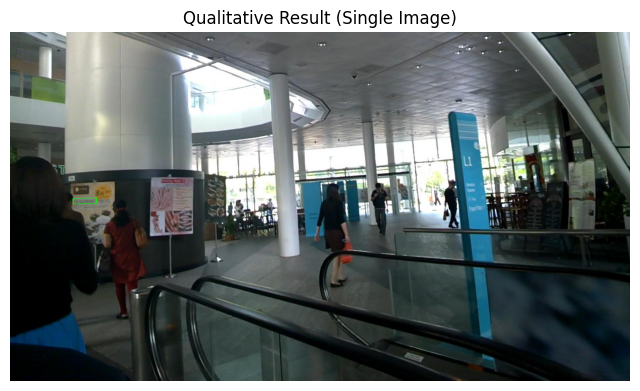

In [13]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

draw = ImageDraw.Draw(img)

if boxes is not None:
    for box in boxes:
        pts = [
            (box[0], box[1]),
            (box[2], box[3]),
            (box[4], box[5]),
            (box[6], box[7])
        ]
        draw.polygon(pts, outline="lime", width=2)

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.axis("off")
plt.title("Qualitative Result (Single Image)")
plt.show()


## Inference Time + FPS + GPU Memory

In [14]:
import time
from torchvision import transforms

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

w, h = img.size
img_r = img.resize(((w//32)*32, (h//32)*32))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

img_tensor = transform(img_r).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    for _ in range(5):
        _ = model(img_tensor)

torch.cuda.synchronize()
start = time.time()

with torch.no_grad():
    _ = model(img_tensor)

torch.cuda.synchronize()
end = time.time()

infer_time = (end - start) * 1000
fps = 1000 / infer_time
peak_mem = torch.cuda.max_memory_allocated() / (1024**3)

print("===== INFERENCE PERFORMANCE =====")
print(f"Inference time : {infer_time:.2f} ms")
print(f"FPS            : {fps:.2f}")
print(f"Peak GPU mem   : {peak_mem:.2f} GB")


===== INFERENCE PERFORMANCE =====
Inference time : 28.28 ms
FPS            : 35.36
Peak GPU mem   : 1.40 GB


## Metrics JSON

In [15]:
import json

final_metrics = {
    "experiment": EXPERIMENT_NAME,
    "dataset": "ICDAR2015",
    "training": loss_log[-1],
    "model": {
        "params_million": total_params / 1e6,
        "gflops": flops / 1e9
    },
    "inference": {
        "time_ms": infer_time,
        "fps": fps,
        "gpu_mem_gb": peak_mem
    }
}

with open(os.path.join(EXP_ROOT, "metrics.json"), "w") as f:
    json.dump(final_metrics, f, indent=2)

print("metrics.json saved")

metrics.json saved


## Save Loss Logs

In [16]:
import json

with open(f"{LOG_DIR}/loss_log.json", "w") as f:
    json.dump(loss_log, f, indent=2)

print("Loss log saved")


Loss log saved


## Batch Inference

In [17]:
from tqdm import tqdm
from PIL import Image
from src.detect import detect

model.eval()

with torch.no_grad():
    pbar = tqdm(sorted(os.listdir(TEST_IMG_DIR)), desc="Batch inference")

    for name in pbar:
        if not name.lower().endswith((".jpg", ".png")):
            continue

        pbar.set_postfix_str(name)

        img = Image.open(os.path.join(TEST_IMG_DIR, name)).convert("RGB")
        boxes = detect(img, model, DEVICE)

        txt_path = os.path.join(
            PRED_DIR, f"res_{os.path.splitext(name)[0]}.txt"
        )

        with open(txt_path, "w") as f:
            if boxes is not None:
                for box in boxes:
                    f.write(",".join(str(int(v)) for v in box[:8]) + "\n")

print("Batch inference done")


Batch inference: 100%|██████████| 500/500 [00:25<00:00, 19.91it/s, img_99.jpg] 

Batch inference done


## ZIP Creation

In [18]:
import zipfile

submit_zip = f"{RESULTS_DIR}/submit.zip"

with zipfile.ZipFile(submit_zip, "w", zipfile.ZIP_DEFLATED) as z:
    for file in os.listdir(PRED_DIR):
        if file.endswith(".txt"):
            z.write(os.path.join(PRED_DIR, file), arcname=file)

print("submit.zip created")


submit.zip created


In [19]:
!python evaluate/script.py \
-g=evaluate/gt.zip \
-s=experiments/exp1_scratch_vgg16/results/submit.zip


Calculated!{"precision": 0.024202510804692323, "recall": 0.2831006259027443, "hmean": 0.04459274988624298, "AP": 0}

In [20]:
# =====================================================
# FINAL FIXED ICDAR METRIC EXTRACTION (100% SAFE)
# =====================================================

import subprocess
import re
import json
import os

GT_ZIP = "evaluate/gt.zip"
SUBMIT_ZIP = f"{EXP_ROOT}/results/submit.zip"
METRICS_JSON = f"{EXP_ROOT}/metrics.json"

cmd = [
    "python", "evaluate/script.py",
    f"-g={GT_ZIP}",
    f"-s={SUBMIT_ZIP}"
]

result = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

output = result.stdout
print(output)

# ----------------------------
# Safe metric extractor
# ----------------------------
def find_metric(pattern, text, group_idx):
    m = re.search(pattern, text, re.IGNORECASE)
    return float(m.group(group_idx)) if m else None

# ----------------------------
# Try standard patterns
# ----------------------------
precision = find_metric(
    r"precision[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

recall = find_metric(
    r"recall[^0-9]*([0-9]+\.[0-9]+)", output, 1
)

f1 = find_metric(
    r"(f[- ]?measure|hmean)[^0-9]*([0-9]+\.[0-9]+)", output, 2
)

# ----------------------------
# Fallback: table format
# ----------------------------
if f1 is None:
    rows = re.findall(
        r"\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|\s*([0-9]+\.[0-9]+)\s*\|",
        output
    )
    if rows:
        precision, recall, f1 = map(float, rows[-1])

# ----------------------------
# Final sanity check
# ----------------------------
if f1 is None:
    raise RuntimeError("ICDAR metrics could not be extracted. Check printed output.")

# ----------------------------
# Save to metrics.json
# ----------------------------
with open(METRICS_JSON, "r") as f:
    metrics = json.load(f)

metrics["icdar"] = {
    "precision": precision,
    "recall": recall,
    "f_measure": f1
}

with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)

print("ICDAR metrics saved successfully")
metrics["icdar"]


Calculated!{"precision": 0.7580381471389646, "recall": 0.6697159364467983, "hmean": 0.7111451942740286, "AP": 0}
ICDAR metrics saved successfully


{'precision': 0.7580381471389646,
 'recall': 0.6697159364467983,
 'f_measure': 0.7111451942740286}